**Статистический анализ данных мобильного приложения сервиса аренды самокатов GoFast**

Проведем анализ данных, полученных из мобильного приложения.

Сервисом GoFast можно пользоваться:

**Без подписки:**
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

**С подпиской Ultra:**
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

План работы:

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчёт выручки
6. Проверка гипотез
7. Распределения

----------------------

Импортируем все библиотеки, которые понадобятся для работы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom

Зададим основные переменные и считаем данные из csv файлов.

In [2]:
users_go = pd.read_csv('/datasets/users_go.csv')
rides_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')


Отобразим первые строки таблиц, чтобы ознакомиться с форматом записи данных.

In [3]:
display('Таблица users_go:', users_go.head(),)
display('Таблица rides_go:', rides_go.head(),)
display('Таблица subscriptions_go:', subscriptions_go)


'Таблица users_go:'

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


'Таблица rides_go:'

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


'Таблица subscriptions_go:'

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Ознакомимся с общей информацией о датафреймах.

In [4]:
print(users_go.info())
print('Количество явных дубликатов в `users_go.csv` = ', users_go.duplicated().sum())
print(rides_go.info())
print('Количество явных дубликатов в `rides_go.csv` = ', rides_go.duplicated().sum())
print(subscriptions_go.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None
Количество явных дубликатов в `users_go.csv` =  31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None
Количество явных дубликатов в `rides_go.csv` = 

Построим гистограммы.

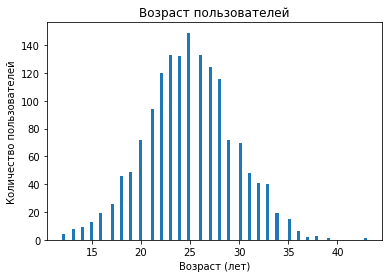

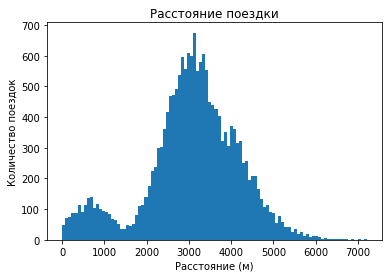

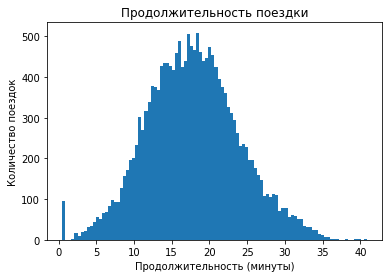

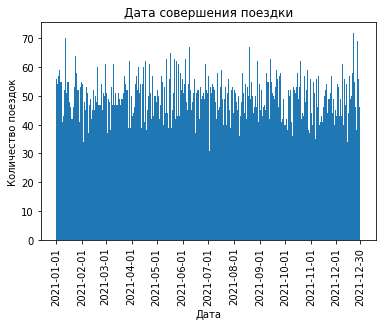

In [5]:
plt.hist(users_go['age'], bins=100)
plt.title('Возраст пользователей')
plt.xlabel('Возраст (лет)')
plt.ylabel('Количество пользователей')
plt.show()

plt.hist(rides_go['distance'], bins=100)
plt.title('Расстояние поездки')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.show()

plt.hist(rides_go['duration'], bins=100)
plt.title('Продолжительность поездки')
plt.xlabel('Продолжительность (минуты)')
plt.ylabel('Количество поездок')
plt.show()

plt.hist(rides_go['date'].sort_values(), bins=len(rides_go['date'].unique()))
plt.title('Дата совершения поездки')
plt.xlabel('Дата')
plt.xticks(rotation=90)
labels = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2021-12-30'] 
x = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2021-12-30'] 
plt.xticks(x, labels, rotation ='vertical')
plt.ylabel('Количество поездок')
plt.show();

По общей информации о данных в датафреймах можно заключить, что:

- users_go 1565 записей, без пропусков, количество явных дубликатов - 31.
- users_go 18068 записей, без пропусков, явные дубликаты отсутствуют.
- subscriptions_go 2 записи, без пропусков, явные дубликаты отсутствуют.

В нескольких столбцах некорректный тип данных. Данные можно признать полными и достаточными для исследования.

# 2. Предобработка данных

Удалим дубликаты в users_go.

In [6]:
users_go = users_go.drop_duplicates()

В rides_go сделаем следующее:
- Округлим расстояние в метрах до двух знаков после запятой.
- Округлим длительность поездки до целых в соответствии с уточненными данными (п. 5.2) и переведем в int.
- Приведём столбец date к формату datetime64.
- Создадим столбец month, содержащий номер месяца из столбца date.

In [7]:
rides_go['distance'] = rides_go['distance'].round(2)
rides_go['duration'] = np.ceil(rides_go['duration']).astype('int')
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')
rides_go['month'] = rides_go['date'].dt.month

In [8]:
print('Записи с ', rides_go['date'].min(), 'по', rides_go['date'].max())

Записи с  2021-01-01 00:00:00 по 2021-12-30 00:00:00


Итоги предобработки данных:
- удалили дубликаты в users_go

В rides_go провели следующие изменения:
- Округлили расстояние в метрах до двух знаков после запятой.
- Округлили длительность поездки до целых в соответствии с уточненными данными (п. 5.2) и переведем в int.
- Привели столбец date к формату datetime64.
- Создали столбец month, содержащий номер месяца из столбца date.

- subscriptions_go оставили без изменений.

# 3. Исследовательский анализ данных

**3.1 Проведем анализ частоты встречаемости городов в нашей выборке данных.**

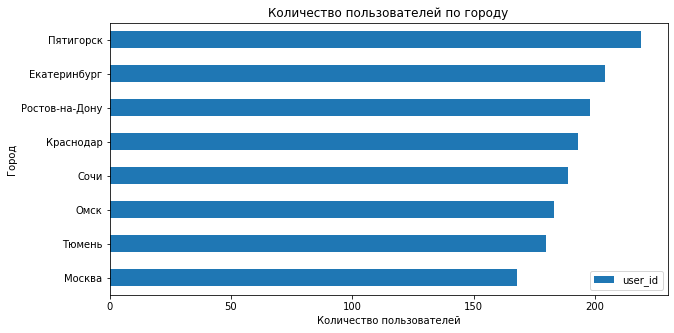

Количество пользователей по городу 


,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [9]:
(
    users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=True)
    .plot(kind='barh', figsize=(10, 5))
)
plt.title('Количество пользователей по городу')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')

plt.show()
print('Количество пользователей по городу ') 
users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

По графику можно заключить, что по количеству пользователей приложения лидирует Пятигорск, следом идут Екатеринбург и Ростов-на-Дону. Несмотря на потенциально большее количество пользователей, Москва находится лишь на восьмой позиции - возможно, это связано с повышенной конкуренцией от других компаний по прокату самокатов. В лидирующей пятерке городов выбивается Екатеринбург - единственный из пяти городов, находящийся не на юге. Лидирование южных городов по количеству пользователей проката самокатов может быть объяснено более длительным летним периодом.

**3.2 Посмотрим на соотношение пользователей с подпиской и без подписки.**

Нагляднее всего будет построить pie-chart:

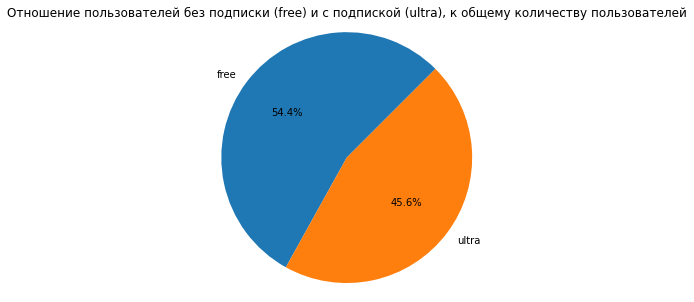

In [10]:
(
    users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
    .plot.pie(y='user_id', figsize=(5,5),  label='',  # Убираем подпись к оси y
    autopct='%1.1f%%', startangle=45, 
    title='Отношение пользователей без подписки (free) и с подпиской (ultra), к общему количеству пользователей', 
    legend=False)  # Отключаем легенду
)
plt.axis('equal')
plt.show()

Больше пользователей пользуются бесплатной версией подписки: 54.4% против 45.6%, пользующихся платной подпиской.

**3.3 Проведем анализ возраста пользователей приложения**

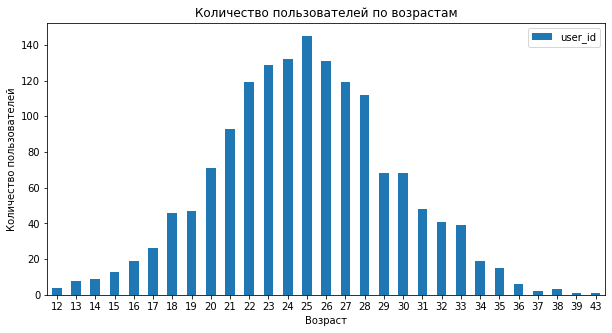

In [11]:
(
    users_go.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age', ascending=True)
    .plot(kind='bar', figsize=(10, 5), rot=0)  # Поворачиваем метки оси X
)
plt.title('Количество пользователей по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()


In [12]:
print('Средний возраст пользователей', users_go['age'].mean().round(1))
users_go['age'].describe()

Средний возраст пользователей 24.9


count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

График распределения количества пользователей по возрасту показывает, что средний возраст потребителей услуги подчиняется нормальному распределению с медианой около 25 лет.

**3.4 Оценим расстояние, которое пользователь преодолел за одну поездку.**

In [13]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

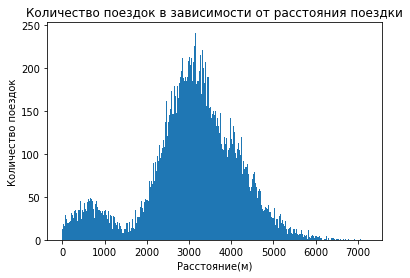

In [14]:
plt.hist(rides_go['distance'], bins=300, range=(1,7211))
plt.title('Количество поездок в зависимости от расстояния поездки')
plt.xlabel('Расстояние(м)')
plt.ylabel('Количество поездок')
plt.show()

- Большинство поездок имеют расстояние от 2000 до 4000 метров. Пик распределения приходится примерно на 3000 метров, где количество поездок достигает максимума (около 250).
- Очень короткие поездки (менее 1000 метров) встречаются реже, но их количество всё же заметно.
- После пика на 3000 метров количество поездок стабильно снижается, хотя поездки до 5000 метров всё еще остаются относительно частыми.
- Медиана равна 3133.61 метра. Это близко к среднему значению, что свидетельствует о симметричности распределения вокруг средней величины.
- Стандартное отклонение составляет 1116.83 метров, что указывает на значительную разбросанность значений. Это видно на графике: хотя основной кластер поездок сосредоточен вокруг 3000 метров, данные распределены по широкому диапазону расстояний.


Первый пик, скорее всего, можно объяснить сценарием использования самоката, в котором пользователю нужно быстро добраться, например, от метро или автобусной остановки до работы - обычно такие расстояния не превышают 1км. Второй пик - сценарий использования, в котором самокат - основное средство передвижения от точки А до точки Б.

**3.5 Проанализируем продолжительность поездок.**

In [15]:
rides_go['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

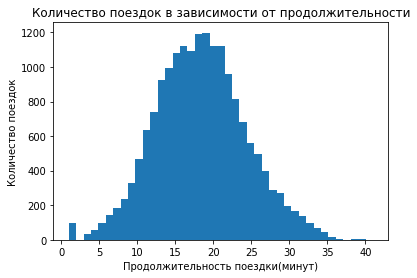

In [16]:
plt.hist(rides_go['duration'], bins=41, range=(1,41))
plt.title('Количество поездок в зависимости от продолжительности')
plt.xlabel('Продолжительность поездки(минут)')
plt.ylabel('Количество поездок')
plt.show()

- Средняя продолжительность поездки составляет 18.5 минут. Это значение на графике располагается близко к пику распределени.
- Стандартное отклонение составляет 6.09 минут, что указывает на умеренную вариацию данных. Хотя большая часть поездок сосредоточена вокруг среднего значения, график показывает заметное количество поездок как с меньшей, так и с большей продолжительностью.
- На гистограмме наблюдается около ста поездок длиной в примерно минуту, возможно, это пользователи которые разблокировали самокат, но никуда не поехали.

Итоги исследовательского анализа данных:
- По данным визуализации можно сделать вывод, что лидером по количеству пользователей проката самокатов является Пятигорск, за которым следуют Екатеринбург и Ростов-на-Дону. Несмотря на то, что Москва потенциально обладает большим числом пользователей, она занимает только восьмую позицию, что может быть связано с высокой конкуренцией на рынке аренды самокатов со стороны других компаний.
Интересным наблюдением является тот факт, что Екатеринбург — единственный город в первой пятерке, который не расположен на юге России. Доминирование южных городов можно объяснить более продолжительным летним сезоном, который увеличивает продолжительность времени, благоприятного для использования самокатов.
- Данные также показывают, что больше пользователей предпочитают бесплатную версию подписки — 54.4% против 45.6%, использующих платную подписку. Это может свидетельствовать о том, что многие пользователи либо не видят необходимости в платной подписке, либо только начинают использовать сервис, не готовые оплачивать услуги сразу.
- Распределение пользователей по возрасту подчиняется нормальному распределению. Средний возраст потребителей проката самокатов составляет около 25 лет, и это значение совпадает с медианой, что говорит о симметричности распределения.
- Большинство поездок имеют длину от 2000 до 4000 метров, с пиком на 3000 метров, где количество поездок достигает максимума около 250. Это означает, что большинство пользователей выбирают поездки средней длины. Медиана расстояния поездки составляет 3133.61 метра, что очень близко к среднему значению. Это свидетельствует о том, что распределение данных относительно симметрично вокруг средней величины. 
- Средняя продолжительность поездки составляет 18.5 минут, что также соответствует пику на графике распределения. На графике также присутствуют поездки с минимальной продолжительностью около одной минуты. Это может означать, что некоторые пользователи разблокировали самокат, но по какой-то причине не совершили поездку, что могло привести к таким коротким временным записям.

# 4. Объединение данных

**4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм.**

In [17]:
df = pd.merge(users_go, subscriptions_go, on='subscription_type')
df = pd.merge(rides_go, df, on='user_id')

In [18]:
print('Количество явных дубликатов в `df` = ', df.duplicated().sum(), '\n')
df.info()

Количество явных дубликатов в `df` =  0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  int64         
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 1.8+ M

In [19]:
df.head()


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Произведено объединение двух таблиц:
- Сначала мы объединили users_go и subscriptions_go по столбцу subscription_type. Это позволило объединить данные пользователей с информацией о подписках, привязанной к каждому типу подписки.
- Затем мы объединенили результат с таблицей rides_go по столбцу user_id, что объединило информацию о поездках с профилями пользователей и их подписками.
- После объединения проведена проверка на наличие явных дубликатов. Результат показал, что количество дубликатов равно нулю, что свидетельствует о корректности объединения данных и отсутствии дублирования записей.

Итого:
В результате объединения, все нужные данные собраны в один датафрейм.
Датафрейм готов к дальнейшему анализу, поскольку:
- Он не содержит пропусков и дубликатов.
- Форматы данных приведены в корректное состояние.
- Общий объем данных составляет 18068 записей, чего достаточно для выполнения статистических расчетов и визуализаций.


**4.2 Создадим два датафрейма: с данными о пользователях с подпиской и без подписки.**

In [20]:
df_free = df[df['subscription_type'] == 'free']
df_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.69,15,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.93,17,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.43,21,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.91,10,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.38,18,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [21]:
df_ultra = df[df['subscription_type'] == 'ultra']
df_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [22]:
total_length = len(df_free) + len(df_ultra)
df_length = len(df)

if df_length == total_length:
    print('Разделение датафреймов прошло успешно')
else:
    print('Разделение датафреймов прошло с ошибками')

Разделение датафреймов прошло успешно


**4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.**


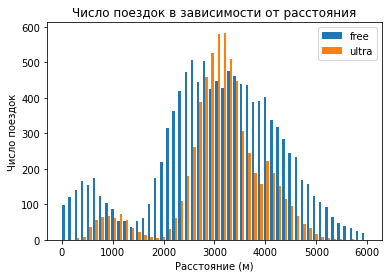

In [23]:
plt.hist([df_free['distance'], df_ultra['distance']], bins=50, range=(1, 6000), label=['free', 'ultra'])
plt.legend()
plt.title('Число поездок в зависимости от расстояния')
plt.xlabel('Расстояние (м)')
plt.ylabel('Число поездок')
plt.show()

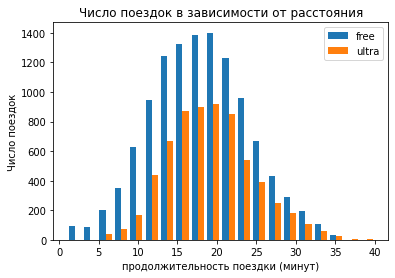

In [24]:
plt.hist([df_free['duration'], df_ultra['duration']], bins=20, range=(1,40), label=['free', 'ultra'])
plt.legend()
plt.title('Число поездок в зависимости от расстояния')
plt.xlabel('продолжительность поездки (минут)')
plt.ylabel('Число поездок')
plt.show()

In [25]:
df_free['distance'].describe()

count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

In [26]:
df_ultra['distance'].describe()


count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

In [27]:
df_free['duration'].describe()


count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [28]:
df_ultra['duration'].describe()


count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

*Вывод по объединению и визуализации данных пользователей с подпиской free и ultra:*

- Хотя средние расстояния, преодолеваемые пользователями Free и Ultra, схожи, пользователи тарифа Free демонстрируют большую изменчивость, иногда проезжая значительно большие расстояния.
- Пользователи тарифа Ultra склонны к поездкам на более постоянные и умеренные дистанции, с меньшим количеством выбросов по сравнению с пользователями Free.
- Пользователи Ultra в среднем имеют более длительными поездки с меньшей изменчивостью по продолжительности. Разница между средним значением и медианой у них меньше, что говорит о меньшей изменчивости.
- Пользователи тарифа Free демонстрируют более широкий диапазон по продолжительности поездок, с большим количеством как коротких, так и длинных поездок.

Таким образом, тип подписки оказывает влияние как на расстояние, так и на длительность поездок.

# 5. Подсчёт выручки

**5.1 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.**

In [29]:
revenue = df.pivot_table(
    index=('user_id', 'month', 'subscription_type'),  # Добавляем subscription_type в индекс
    values=(
        'distance', 
        'duration', 
        'minute_price', 
        'start_ride_price', 
        'subscription_fee'
    ), 
    aggfunc={
        'distance': {'count', 'sum'}, 
        'duration': 'sum',
        'minute_price': 'mean',
        'start_ride_price': 'mean',
        'subscription_fee': 'mean'
    }
)

revenue.columns = [
    'count', 'distance', 
    'duration', 
    'minute_price',
    'start_ride_price', 
    'subscription_fee'
]

revenue.head()


count  distance  duration  minute_price  \
user_id month subscription_type                                            
1       1     ultra                  2   7027.51        42             6   
        4     ultra                  1    754.16         7             6   
        8     ultra                  2   6723.47        46             6   
        10    ultra                  2   5809.91        32             6   
        11    ultra                  3   7003.50        56             6   

                                 start_ride_price  subscription_fee  
user_id month subscription_type                                      
1       1     ultra                             0               199  
        4     ultra                             0               199  
        8     ultra                             0               199  
        10    ultra                             0               199  
        11    ultra                             0               199

**5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.**

In [30]:
revenue['revenue'] = (
revenue['start_ride_price']*revenue['count']+
revenue['minute_price']*revenue['duration']+
revenue['subscription_fee'])

print('Записи с ', df['date'].min(), 'по', df['date'].max())
print ('Выручка за 2021 год:',revenue['revenue'].sum(), 'рублей.')

Записи с  2021-01-01 00:00:00 по 2021-12-30 00:00:00
Выручка за 2021 год: 3878641 рублей.


Годовая выручка сервиса аренды самокатов «GoFast» составила 3 878 641 рубль.

# 6. Проверка гипотез

**6.1 Проверим, тратят ли пользователи с подпиской больше времени на поездки?**

Сформулируем следующие гипотезы:

- Н0: Средняя продолжительность поездок с подпиской равна средней продолжительности поездок без подписки.

- Н1: Средняя продолжительность поездок с подпиской превышает среднюю продолжительность поездок без подписки.

Для проверки этих гипотез используем исходные данные о продолжительности каждой сессии, разделив их на группы подписчиков и пользователей без подписки.

In [31]:
p_value = st.ttest_ind(df_ultra['duration'], df_free['duration'], equal_var=True, alternative='greater').pvalue
print(p_value)

# Проверяем гипотезу
if p_value < 0.05:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не отвергаем нулевую гипотезу.')

2.4959453720736625e-34
Отвергаем нулевую гипотезу.


**Вывод**: Поскольку p-значение значительно меньше уровня значимости α = 0.05, мы отвергаем нулевую гипотезу. Это означает, что средняя продолжительность поездок с подпиской статистически значимо превышает среднюю продолжительность поездок без подписки.

**6.2 Проверим, не превышает ли среднее расстояние одной поездки пользователей с подпиской 3130 метров, оптимальное с точки зрения износа самоката.**

Сформулируем следующие гипотезы:
- Н0: Среднее расстояние одной поездки пользователей с подпиской Ultra равно оптимальному значению в 3130 метров.
- Н1: Среднее расстояние одной поездки пользователей с подпиской Ultra превышает оптимальное значение в 3130 метров.

Проверим гиотезы:

In [32]:
optimal_distance = 3130
alpha = 0.05

p_value = st.ttest_1samp(df_ultra['distance'], optimal_distance, alternative='greater').pvalue
print(f"P-значение: {p_value}")

# Проверяем гипотезу
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

P-значение: 0.9195362605842414
Не отвергаем нулевую гипотезу


**Вывод:**
Поскольку полученное p-значение (0.9195) значительно превышает уровень значимости α = 0.05, мы не можем отвергнуть нулевую гипотезу. Это означает, что на основании представленных данных нет статистически значимых доказательств того, что среднее расстояние одной поездки пользователей с подпиской Ultra превышает оптимальное значение в 3130 метров.

**6.3 Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**

Сформулируем следующие гипотезы:
- Н0: Средняя ежемесячная выручка от пользователей с подпиской равна средней ежемесячной выручке от пользователей без подписки.

- Н1: Средняя ежемесячная выручка от пользователей с подпиской превышает среднюю ежемесячную выручку от пользователей без подписки.

In [33]:
alpha = 0.05

revenue_with_sub = revenue[revenue['subscription_fee'] > 0]['revenue']
revenue_without_sub = revenue[revenue['subscription_fee'] == 0]['revenue']

t_stat, p_value = st.ttest_ind(revenue_with_sub, revenue_without_sub, equal_var=True, alternative='greater')

print(f"P-значение: {p_value:.4e}")

# Проверяем гипотезу:
if p_value < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не отвергаем нулевую гипотезу.')


P-значение: 1.8850e-31
Отвергаем нулевую гипотезу.


**Вывод**: Поскольку полученное p-значение значительно меньше уровня значимости α = 0.05, мы отвергаем нулевую гипотезу. Это указывает на то, что существует статистически значимое различие в помесячной средней выручке между пользователями с подпиской и без подписки.

Средняя помесячная выручка от пользователей с подпиской значительно превышает среднюю помесячную выручку от пользователей без подписки.

**6.4. Разберем ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

Для проверки гипотезы о том, что обновление серверов привело к значительному снижению количества обращений в техподдержку, необходимо использовать парный t-тест (t-тест для зависимых выборок).
Если одна и та же переменная измеряется дважды для одних и тех же пользователей и выборки равны по размеру, можно использовать метод scipy.stats.ttest_rel(). 

**Общие выводы**:

- По графику распределения количества пользователей по городам видно, что Пятигорск лидирует по количеству пользователей приложения, за ним идут Екатеринбург и Ростов-на-Дону. Несмотря на потенциально большее население, Москва занимает лишь восьмую позицию, возможно, из-за высокой конкуренции среди прокатных компаний. В первой пятерке Екатеринбург выделяется как единственный город, не находящийся на юге России. Преобладание южных городов объясняется более длительным летним периодом, способствующим увеличению использования самокатов.
- Мы выяснили,что больше пользователей пользуются бесплатной версией подписки: 54.4% против 45.6%, пользующихся платной подпиской.
- График распределения пользователей по возрасту показал, что средний возраст пользователей приложения распределён нормально, с медианой около 25 лет.

Анализ количества поездок в зависимости от расстояния показал следующее:
- Большинство поездок составляют от 2000 до 4000 метров, с наибольшим количеством около 3000 метров.
- Короткие поездки (менее 1000 метров) встречаются реже, но их количество заметно.
- Длинные поездки после 3000 метров становятся всё менее частыми, хотя до 5000 метров ещё достаточно распространены.
- Среднее расстояние поездки около 3134 метров, что показывает равномерное распределение.
- Разнообразие поездок большое: большинство около 3000 метров, но есть как значительно короткие, так и длинные поездки.

- Средняя продолжительность поездки составляет 18.5 минут, что также соответствует пику на графике распределения. На графике также присутствуют поездки с минимальной продолжительностью около одной минуты. Это может означать, что некоторые пользователи разблокировали самокат, но по какой-то причине не совершили поездку, что могло привести к таким коротким временным записям.

Было показано, что тип подписки оказывает влияние как на расстояние, так и на длительность поездок:
- Хотя средние расстояния, преодолеваемые пользователями Free и Ultra, схожи, пользователи тарифа Free демонстрируют большую изменчивость, иногда проезжая значительно большие расстояния.
- Пользователи тарифа Ultra склонны к поездкам на более постоянные и умеренные дистанции, с меньшим количеством выбросов по сравнению с пользователями Free.
- Пользователи Ultra в среднем имеют более длительными поездки с меньшей изменчивостью по продолжительности. Разница между средним значением и медианой у них меньше, что говорит о меньшей изменчивости.
- Пользователи тарифа Free демонстрируют более широкий диапазон по продолжительности поездок, с большим количеством как коротких, так и длинных поездок.

Годовая выручка сервиса аренды самокатов «GoFast» составила 3 878 641 рубль.

По результатам проверки гипотез можно заключить следующее:
- Пользователи с подпиской совершают в среднем более длительные поездки, чем без подписки.
- Среднее расстояние поездок подписчиков не превышает оптимальных 3130 метров.
- Подписчики приносят больше месячной выручки, чем пользователи без подписки.

Как итог, можно утверждать, что пользователи с подпиской более ценны для сервиса аренды самокатов.